#  Building a Robust Data Pipeline


**TASK**

* Access and explore the structure of an image dataset.
* Build a custom `Dataset` class to load images and labels on demand.
* Define a series of `transformations`, including resizing, tensor conversion, and `normalization`, to preprocess the data.
* Define augmentation transforms to enhance the training dataset.
* Split the dataset into training, validation, and test sets applying the appropriate transforms to each and creating `DataLoader` instances for efficient batching.



<a name='imports'></a>
## Imports

In [1]:
import pandas as pd
import torch
from torch.utils.data import Dataset, Subset, DataLoader, random_split
from torchvision import transforms
from PIL import Image

In [2]:
import helper_utils
import unittests

<a name='1---data-access'></a>
## 1 - Data Access 

<a name='11---exploring-the-dataset'></a>
### 1.1 - Exploring the Dataset

The first step when working with any new dataset is to explore it. This involves understanding its structure, the types of data it contains, and identifying any potential issues such as missing values or outliers.

In [3]:
path_dataset = './plants_dataset'

helper_utils.print_data_folder_structure(path_dataset, max_depth=1)

plants_dataset/
├── classname.txt
├── df_labels.csv
├── df_labels_orig.csv
├── aloevera/
├── banana/
├── bilimbi/
├── cantaloupe/
├── cassava/
├── coconut/
├── corn/
├── cucumber/
├── curcuma/
├── eggplant/
├── galangal/
├── ginger/
├── guava/
├── kale/
├── longbeans/
├── mango/
├── melon/
├── orange/
├── paddy/
├── papaya/
├── peperchili/
├── pineapple/
├── pomelo/
├── shallot/
├── soybeans/
├── spinach/
├── sweetpotatoes/
├── tobacco/
├── waterapple/
└── watermelon/


I have an initial understanding of the dataset structure:
- `df_labels.csv`,
- `classname.txt`,
- One folder per class, each containing the images for that class (all in `.jpg` format).

This information will be useful when I design my custom Dataset class later on.

In [4]:
# print the content of `df_labels.csv`
df_labels = pd.read_csv(f'{path_dataset}/df_labels.csv')
print(df_labels.head())

                 image:FILE  category
0  aloevera/aloevera700.jpg         0
1  aloevera/aloevera701.jpg         0
2  aloevera/aloevera702.jpg         0
3  aloevera/aloevera703.jpg         0
4  aloevera/aloevera704.jpg         0


In [5]:
# print the content of `class_names.txt`
with open(f'{path_dataset}/classname.txt', 'r') as f:
    class_names = f.read().splitlines()
print(class_names)

['aloevera', 'banana', 'bilimbi', 'cantaloupe', 'cassava', 'coconut', 'corn', 'cucumber', 'curcuma', 'eggplant', 'galangal', 'ginger', 'guava', 'kale', 'longbeans', 'mango', 'melon', 'orange', 'paddy', 'papaya', 'peperchili', 'pineapple', 'pomelo', 'shallot', 'soybeans', 'spinach', 'sweetpotatoes', 'tobacco', 'waterapple', 'watermelon']


I’ve verified that `df_labels.csv` contains the labels for each image along with their corresponding file names, and that `classname.txt` contains the names of all the classes.

<a name='12---creating-a-custom-dataset-class'></a>
### 1.2 - Creating a Custom Dataset Class

It is now time to create a custom dataset class to handle the plant images dataset. 
This class will inherit from `torch.utils.data.Dataset` and will be responsible for loading and preprocessing the images along with their corresponding labels.

In [ ]:
#  PlantsDataset
class PlantsDataset(Dataset):
    """
    ExDataset is a custom PyTorch Dataset for loading images and their corresponding labels from a specified directory and CSV file.

    Args:
        root_dir (str): Root directory containing the dataset files, including 'classname.txt'.
        transform (callable, optional): Optional transform to be applied on a sample.
    """

    def __init__(self, root_dir, transform=None):
        """
        Initializes the dataset object.
        """

        # Initialize path to root directory and transformations
        self.root_dir = root_dir
        self.transform = transform

        # Read the CSV file (with images path and category labels)
        self.df_info = self.read_df()

        # Load labels from the DataFrame using the `load_labels` method
        self.labels = self.load_labels(self.df_info)

        # Create a mapping from label integers to class names using the `read_classname` method
        self.class_names = self.read_classname()

    def read_df(self):
        path_csv = self.root_dir + "/df_labels.csv"
        df = pd.read_csv(path_csv)
        return df

    def read_classname(self):
        path_txt = self.root_dir + "/classname.txt"
        with open(path_txt, "r") as f:
            class_names = f.read().splitlines()
        return class_names

    def load_labels(self, df):
        labels = []
        for idx, row in df.iterrows():
            label_int = row["category"]
            labels.append(label_int)
        return labels

    def get_label_description(self, label: int):
        description = self.class_names[label]
        return description

    def retrieve_image(self, idx: int):
        img_path = self.root_dir + "/" + self.df_info.iloc[idx]["image:FILE"]
        with Image.open(img_path) as img:
            image = img.convert("RGB")
        return image

    def __len__(self):
        """
        Returns the number of samples in the dataset.
        """
        # Return the total number of samples from the `.labels` attribute
        length = len(self.labels)
        return length

    def __getitem__(self, idx):
        """
        Retrieves the image and its corresponding label at the specified index.
        """
        # Retrieve the image using the `retrieve_image` method
        image = self.retrieve_image(idx)

        # Apply the specified transformations to the image, if any
        # The None of the if condition is not part of the exercise, leave it as is
        if self.transform is not None:
            image = self.transform(image)

        # Retrieve the label from the `labels` attribute
        label = self.labels[idx]

        # Return the image and label
        return image, label  


In [7]:
plants_dataset = PlantsDataset(root_dir=path_dataset, transform=None)

In [8]:
# print the length of the dataset
print(f'Length of the dataset: {len(plants_dataset)}')

Length of the dataset: 3000


Description: aloevera
Image shape: (269, 187)


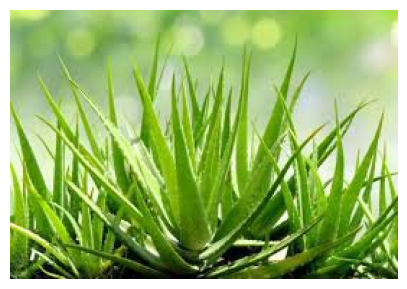

In [9]:
# Look at a sample to check it's working correctly
sel_idx = 10
img, label = plants_dataset[sel_idx]

# Visualize the image
helper_utils.plot_img(img)

# Print its description
print(f'Description: {plants_dataset.get_label_description(label)}')

# Print its shape
print(f'Image shape: {img.size}')  # PIL image size is (width, height)

<a name='13---overview-of-the-images-in-the-dataset'></a>
### 1.3 - Overview of the images in the dataset


In this step, I’ll explore the dataset using the `visual_exploration` function from `helper_utils`.
This function displays a few sample images along with their labels, allowing to visually inspect the data and get a sense of its main characteristics.

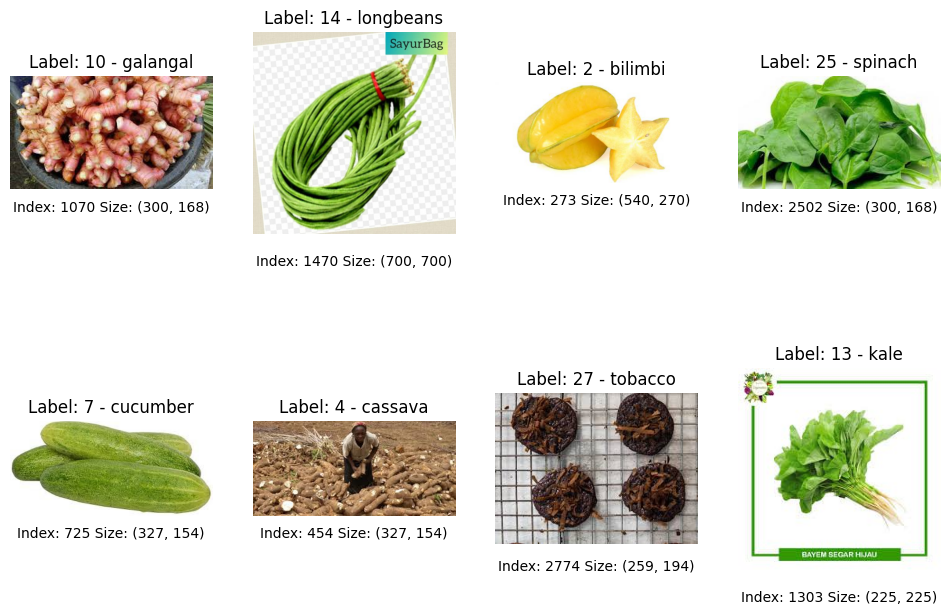

In [11]:
helper_utils.visual_exploration(plants_dataset, num_rows=2, num_cols=4)

From the visual exploration, it can be seen that the images in the dataset vary in size, color, and background.
This kind of variability is common in real-world datasets and underscores the importance of preprocessing steps such as resizing, normalization, and data augmentation to help the model generalize effectively across different types of images.

<a name='2---transformations'></a>
## 2 - Transformations

Before feeding images into a neural network, I need to preprocess them using a series of transformations.
These steps include resizing the images to a consistent size, converting them into tensors, and normalizing their pixel values.

<a name='21---computing-mean-and-standard-deviation'></a>

### 2.1 - Computing Mean and Standard Deviation

Below is an auxiliary function `get_mean_std` that computes the mean and standard deviation of the training dataset.
These statistics are required for the normalization step in the preprocessing pipeline.

Since resizing and converting images to tensors changes the pixel value distribution, the mean and standard deviation must be computed after these transformations are applied.

In `get_mean_std`, I will:

* **Preprocessing Setup**:
A transform pipeline resizes images to 128×128 and converts them to tensors.

* **First Pass — Compute Mean**:
For each image, the pixels are flattened, and the channel-wise pixel values are summed globally across the entire dataset.
Dividing by the total number of pixels yields the channel-wise mean.

* **Second Pass — Compute Standard Deviation**:
With the mean known, I compute the squared difference between each pixel and its channel mean, accumulate across the dataset, and then take the square root to obtain the channel-wise standard deviation.

**Note**:
The mean and standard deviation should usually be computed only on the training set.
Using statistics computed from the test or validation data can introduce data leakage, where information from the evaluation set influences the training process.
In this case, since at this point the data has not yet been split, I will compute the statistics on the entire dataset for simplicity.
The mean and standard deviation values I obtain here will not change much when computed solely on the training set.

In [15]:
def get_mean_std(dataset: Dataset):
    preprocess = transforms.Compose(
        [transforms.Resize((128, 128)), transforms.ToTensor()]
    )
    
    # First pass: compute mean
    total_pixels = 0
    sum_pixels = torch.zeros(3)
    
    for img, _ in dataset:
        img_tensor = preprocess(img)
        pixels = img_tensor.view(3, -1)  # [channels, pixels]
        sum_pixels += pixels.sum(dim=1)
        total_pixels += pixels.size(1)
    
    mean = sum_pixels / total_pixels
    
    # Second pass: compute std
    sum_squared_diff = torch.zeros(3)
    
    for img, _ in dataset:
        img_tensor = preprocess(img)
        pixels = img_tensor.view(3, -1)  # [channels, pixels]
        diff = pixels - mean.unsqueeze(1)
        sum_squared_diff += (diff ** 2).sum(dim=1)
    
    std = torch.sqrt(sum_squared_diff / total_pixels)
    
    return mean, std

In [16]:
# Define the transformations to make to the images
mean, std = get_mean_std(plants_dataset)

print(f"Mean: {mean}, Std: {std}")

Mean: tensor([0.6659, 0.6203, 0.4784]), Std: tensor([0.2888, 0.2884, 0.3426])


<a name='22---defining-transformations'></a>
### 2.2 - Defining Transformations

Having computed the mean and standard deviation of the dataset, I can now define the transformations to apply to the images.
I’ll create two sets of transformations: one for the training set, which includes data augmentation, and another for the validation and test sets.

In [ ]:
#  get_transformations
def get_transformations(mean, std):
    """
    Returns two sets of image transformation pipelines.
    """
    main_tfs = [  
        # Resize images to 128x128 pixels
        transforms.Resize((128, 128)),
        # Convert images to PyTorch tensors
        transforms.ToTensor(),
        # Normalize images using the provided mean and std
        transforms.Normalize(mean, std)
    ]  

    augmentation_tfs = [  
        # Randomly flip the image vertically
        transforms.RandomVerticalFlip(),
        # Randomly rotate the image by ±15 degrees
        transforms.RandomRotation(15)
    ]  

    # Compose the main transformations into a single pipeline
    main_transform = transforms.Compose(main_tfs)

    # Compose augmentation + main transforms
    transform_with_augmentation = transforms.Compose(augmentation_tfs + main_tfs)

    return main_transform, transform_with_augmentation

In [18]:
# Get the transformations
main_transform, transform_with_augmentation = get_transformations(mean, std)

# Print the transformations to verify
print(main_transform)
print(transform_with_augmentation)

Compose(
    Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=tensor([0.6659, 0.6203, 0.4784]), std=tensor([0.2888, 0.2884, 0.3426]))
)
Compose(
    RandomVerticalFlip(p=0.5)
    RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
    Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=tensor([0.6659, 0.6203, 0.4784]), std=tensor([0.2888, 0.2884, 0.3426]))
)


Transformed Image shape: torch.Size([3, 128, 128])


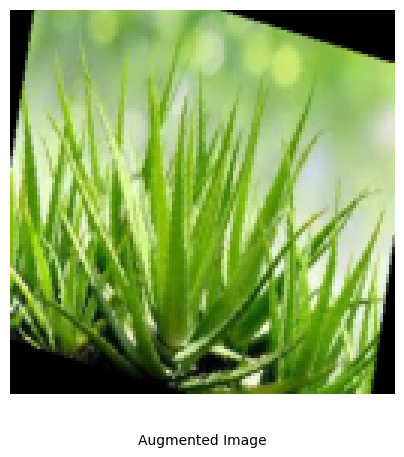

In [20]:
# Check main_transform on a sample image
img_transformed = main_transform(img)
print(f"Transformed Image shape: {img_transformed.shape}")


# get denormalization function
denormalize = helper_utils.Denormalize(mean, std)
# visualize the augmented image
img_augmented = transform_with_augmentation(img)
helper_utils.plot_img(denormalize(img_augmented), info=f"Augmented Image")

<a name='3---data-loading'></a>
## 3 - Data Loading

With the custom dataset class and transformations defined, I can now create data loaders to efficiently load and batch data for training and evaluation. This is the final step before I would train a neural network on this dataset.



In [21]:
class SubsetWithTransform(Dataset):
    """A subset of a dataset with a specific transform applied."""

    def __init__(self, subset: Subset, transform=None):
        # subset should be a subset WITHOUT transform
        self.subset = subset
        self.transform = transform

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        image, label = self.subset[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
#  get_dataloaders
def get_dataloaders(
    dataset,
    batch_size,
    val_fraction,
    test_fraction,
    main_transform,
    augmentation_transform,
):
    """
    Splits a dataset into training, validation, and test sets, applies specified transforms to each split,
    and returns corresponding DataLoader objects.
    """

    # Calculate the sizes of each split
    total_size = len(dataset)
    val_size = int(total_size * val_fraction)
    test_size = int(total_size * test_fraction)
    train_size = total_size - val_size - test_size

   

    # Split the dataset into training, validation, and test sets
    train_dataset, val_dataset, test_dataset = random_split(
        dataset, [train_size, val_size, test_size]
    )  

    # Create dataset with the corresponding transforms for each split
    # (Assuming you have a wrapper like SubsetWithTransform(subset, transform))
    train_dataset = SubsetWithTransform(train_dataset, augmentation_transform)
    val_dataset   = SubsetWithTransform(val_dataset, main_transform)
    test_dataset  = SubsetWithTransform(test_dataset, main_transform)

    # Create DataLoaders for each split
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)


    return train_loader, val_loader, test_loader

In [23]:
train_loader, val_loader, test_loader = get_dataloaders(
    dataset=plants_dataset,
    batch_size=32,
    val_fraction=0.15,
    test_fraction=0.2,
    main_transform=main_transform,
    augmentation_transform=transform_with_augmentation,
)

In [24]:
print('=== Train Loader ===')
print(f"Number of batches in train_loader: {len(train_loader)}")
train_dataset = train_loader.dataset
print(f"Number of samples in train_dataset: {len(train_dataset)}")
print(f"Transforms applied to train_dataset: {train_dataset.transform}")
print(f"train_dataset type: {type(train_dataset)}")

print('\n=== Test Loader ===')
print(f"Number of batches in test_loader: {len(test_loader)}")
test_dataset = test_loader.dataset
print(f"Number of samples in test_dataset: {len(test_dataset)}")
print(f"Transforms applied to test_dataset: {test_dataset.transform}")
print(f"test_dataset type: {type(test_dataset)}")

=== Train Loader ===
Number of batches in train_loader: 61
Number of samples in train_dataset: 1950
Transforms applied to train_dataset: Compose(
    RandomVerticalFlip(p=0.5)
    RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
    Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=tensor([0.6659, 0.6203, 0.4784]), std=tensor([0.2888, 0.2884, 0.3426]))
)
train_dataset type: <class '__main__.SubsetWithTransform'>

=== Test Loader ===
Number of batches in test_loader: 19
Number of samples in test_dataset: 600
Transforms applied to test_dataset: Compose(
    Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=tensor([0.6659, 0.6203, 0.4784]), std=tensor([0.2888, 0.2884, 0.3426]))
)
test_dataset type: <class '__main__.SubsetWithTransform'>
